In [ ]:
!pip install optuna
!pip install augly
!apt-get install libmagic-dev
!pip install python-magic

In [ ]:
from PIL import Image, ImageOps
import numpy as np
from numpy import asarray
import sklearn
from skimage.transform import resize
from os import listdir
from os.path import isfile, join
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import LeaveOneOut, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from itertools import product
import optuna
#Get access to image folders
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In this tutorial, we will attempt to build a classifier which can identify between blood histologies which present for sickle cell anemia versus those that are non-presenting for the condition.

Images are drawn from Google images.


In [ ]:
#Healthy red blood cells
#Dig through files, create an array containing filenames for healthy and sickle cells
healthy_dir = [ join('drive/My Drive/healthy',f) for f in listdir('drive/My Drive/healthy') if isfile(join('drive/My Drive/healthy',f))] 
sickle_dir = [ join('drive/My Drive/sickle',f) for f in listdir('drive/My Drive/sickle') if isfile(join('drive/My Drive/sickle',f))]

#Now let's convert these images into NumPy arrays.
healthy_imgs=[]
sickle_imgs=[]

#Do conversion JPEG --> NumPy arrays for all healthy cell pictures. 
for file in healthy_dir:
    #Directory contains hidden files...this is specific to Mac OS
    if file == 'drive/My Drive/healthy/.DS_Store':
        continue
    img = Image.open(file)
    # asarray() class is used to convert
    # PIL images into NumPy arrays
    numpydata = asarray(img)
    healthy_imgs.append(numpydata)

#Do conversion JPEG --> NumPy arrays for all sickle cell images.
for file in sickle_dir:
    if file == 'drive/My Drive/sickle/.DS_Store':
        continue
    img = Image.open(file)
    # asarray() class is used to convert
    # PIL images into NumPy arrays
    numpydata = asarray(img)
    sickle_imgs.append(numpydata)

If we convert a JPEG to an array using Pillow, what are its dimensions? Let's take a look.

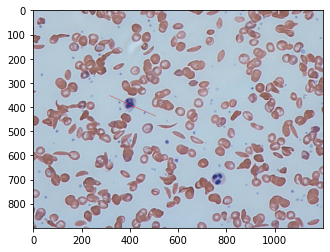

In [ ]:
file=sickle_dir[0]
#We'll use matplot lib to display the image.
img = Image.open(file)
imgplot = plt.imshow(img)
plt.show()
# asarray() class is used to convert
# PIL images into NumPy arrays
numpydata = asarray(img)
  
# <class 'numpy.ndarray'>
print(type(numpydata))

#  shape
print(numpydata.shape)

The format here is  𝐇𝐞𝐢𝐠𝐡𝐭 𝐱 𝐖𝐢𝐝𝐭𝐡 𝐱 𝐂𝐨𝐥𝐨𝐫 . Notice that dim(Color)=3. This is because Pillow (and most image processing libraries) will try to coerce an image file into a RGB (Red-Green-Blue). Each pixel has 3 layers to it: its red, green, and blue value, each on a scale of 0-255.

In any case, our images have to be pretty standardized, so we need them all to be the same size.

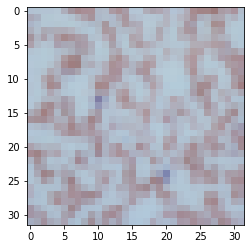

In [ ]:
#Resizing is possible using pillow. Let's go down to 128x128 and see what happens. Moving from
#a higher to lower resolution is always preferable. 
img_resized = resize(sickle_imgs[0], (32, 32,3))
np.shape(img_resized)
img_resized = Image.fromarray((img_resized * 255).astype(np.uint8))
imgplot = plt.imshow(img_resized)

The image is more or less intact. Sickle shapes are still identifiable.

In [ ]:
healthy_transform=[]
sickle_transform=[]

#Healthy image conversion. 
for im in healthy_imgs:
    new_im=resize(im, (32, 32 ,3))
    healthy_transform.append(new_im)

#Sickle image conversion
for im in sickle_imgs:
    new_im=resize(im, (32, 32 ,3))
    sickle_transform.append(new_im)

In [ ]:
#Create the labels. Binary classifier with sickle=0, healthy=1. We have 86 images
#healthy blood cells and 68 of sickle cells. 
healthy_labels = 86*[0]
sickle_labels = 68*[1]
#Join for one final label list.
y=asarray(healthy_labels+sickle_labels)

#Join all data arrays for a final dataset. 
X=asarray(healthy_transform+sickle_transform)
np.shape(X)

(154, 32, 32, 3)

We're going to run through a variety of models and measure their accuracy.


In [ ]:
#For these simple classifiers we actually need reshape the 128x128 images into a single vector. 
def ml(X, y, model, folds=0):
  X_final=[]
  for im in X:
      X_final.append(np.reshape(im,(3072,)))
  X_final=asarray(X_final)

  #Sci-kit learn comes with a leave-one-out object which will split your data for you.
  if not folds: 
    cv = LeaveOneOut()
  else:
    cv = KFold(n_splits=folds)

  y_true, y_pred = list(), list()
  for train_ix, test_ix in cv.split(X_final):
     # split data into test and train. In our case test is a single datapoint which is the most aggressive. 
      X_train, X_test = X_final[train_ix,:], X_final[test_ix, :]
      y_train, y_test = y[train_ix], y[test_ix]

      #Select model
      model=model
      #Train the model
      model.fit(X_train, y_train)
    
      #Evaluate model -- make it predict on test. 
      yhat = model.predict(X_test)

      #Store the true label alongside the predicted label. 
      y_true.append(y_test[0])      
      y_pred.append(yhat[0])

  #Calculate the accuracy -- how many times did we get it right versus wrong?
  acc = accuracy_score(y_true, y_pred)
  print('Accuracy: %.7f' % acc)
  print(confusion_matrix(y_true, y_pred))


## K-Nearest Neighbors

In [ ]:
ml(X,y,KNeighborsClassifier(n_neighbors=7))

Accuracy: 0.5844156
[[82  4]
 [60  8]]


Not great. The majority class is healthy, which makes up 86/154 = 0.558 of the total images. Essentially, if we were to just guess everything as healthy, we would be 56% accurate, so nearest neighbors edges it out, but not by much.

## Random Forest Classifier

In [ ]:
ml(X,y,RandomForestClassifier())

Accuracy: 0.7792208
[[73 13]
 [21 47]]


Now we're talking. We haven't even fine-tuned this yet and we're 78% accurate. The majority of both classes are being predicted well. Let's see if we can do even better. 

## SVM (linear kernel)

In [ ]:
ml(X,y,SVC(kernel='linear'))

Accuracy: 0.7857143
[[80  6]
 [27 41]]


These simpler models performed decently. Since the Random Forest Classifier was reasonably fast to train and performed well, we will fine-tune it. We shall use Optuna to do this. 

## Fine-tuning

In [ ]:
from sklearn.model_selection import cross_val_score, cross_val_predict

X_final=[]
for _ in X:
    X_final.append(np.reshape(_,(3072)))
X_final=asarray(X_final)

def objective(trial):
    classifier_name = trial.suggest_categorical("classifier", ["RFC"])
    n_estimators = trial.suggest_int("n_estimators", 10, 150, log=True)
    max_depth= trial.suggest_int("max_depth", 2, 10, log=True)
    #min_samples_split = trial.suggest_float('min_samples_split',0.1, 1.0,log =True)
    classifier_obj = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
    cv = LeaveOneOut()
    y_pred = cross_val_predict(classifier_obj, X_final, y, cv=cv)
    accuracy = accuracy_score(y, y_pred)
    return accuracy

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
print(study.best_trial)

[I 2022-08-12 20:17:17,584] A new study created in memory with name: no-name-92e9edc4-943f-4290-85e2-e0ff745814ff
[I 2022-08-12 20:17:47,923] Trial 0 finished with value: 0.7662337662337663 and parameters: {'classifier': 'RFC', 'n_estimators': 45, 'max_depth': 6}. Best is trial 0 with value: 0.7662337662337663.
[I 2022-08-12 20:19:07,337] Trial 1 finished with value: 0.7467532467532467 and parameters: {'classifier': 'RFC', 'n_estimators': 131, 'max_depth': 6}. Best is trial 0 with value: 0.7662337662337663.
[I 2022-08-12 20:19:12,981] Trial 2 finished with value: 0.6623376623376623 and parameters: {'classifier': 'RFC', 'n_estimators': 12, 'max_depth': 2}. Best is trial 0 with value: 0.7662337662337663.
[I 2022-08-12 20:19:19,436] Trial 3 finished with value: 0.6818181818181818 and parameters: {'classifier': 'RFC', 'n_estimators': 12, 'max_depth': 3}. Best is trial 0 with value: 0.7662337662337663.
[I 2022-08-12 20:19:34,202] Trial 4 finished with value: 0.6688311688311688 and parameter

We were able to increase the model to >80% accuracy. A higher number of trials might have been able to get us more. 

## Expanding our small dataset using augly.

First we will balance our sets so both sets are equally represented.

In [ ]:
for i in range(18):
  healthy_transform=np.delete(healthy_transform,-1,0)

In [ ]:
def split(img, d):
    tile_imgs=[]
    img=Image.fromarray(img, mode=None)
    w, h = img.size

    grid = product(range(0, h-h%d, d), range(0, w-w%d, d))
    for i, j in grid:
        box = (j, i, j+d, i+d)
        new_img=img.crop(box)
        tile_imgs.append(asarray(new_img))
    return tile_imgs

Now we will augment/expand our dataset. As long the labels are still valid, adding manipulations such as flipping, blurring, etc. will form new data points that our model can learn from. 

In [ ]:
#Convert everything back to a PIL image.
total_imgs={}
healthy_imgs=[]
sickle_imgs=[]

for img in healthy_transform:
    new_img = Image.fromarray((img * 255).astype(np.uint8))
    healthy_imgs.append(new_img)

for img in sickle_transform:
    new_img = Image.fromarray((img * 255).astype(np.uint8))
    sickle_imgs.append(new_img)

total_imgs['healthy'] = healthy_imgs
total_imgs['sickle'] = sickle_imgs

In [ ]:
import os
import augly.image as imaugs
import augly.utils as utils

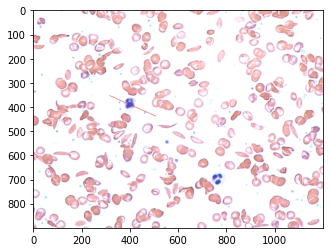

In [ ]:
#Brighten images
bright_imgs={}

for status in total_imgs:
    bright_imgs[status]=[]
    for img in total_imgs[status]:
          new_img = imaugs.brightness(img, factor=1.7)
          bright_imgs[status].append(new_img)

imgplot = plt.imshow(imaugs.brightness(Image.open(sickle_dir[0]),factor=1.5))

total_imgs['healthy'] += bright_imgs['healthy']
total_imgs['sickle'] += bright_imgs['sickle']

In [ ]:
#Flipping
horz_imgs={}
ver_imgs={}

#Horizontal flip
for status in total_imgs:
    horz_imgs[status]=[]
    for img in total_imgs[status]:
      new_img = imaugs.hflip(img)
      horz_imgs[status].append(new_img)

#Vertical flip
for status in total_imgs:
    ver_imgs[status]=[]
    for img in total_imgs[status]:
      new_img = imaugs.hflip(img)
      ver_imgs[status].append(new_img)

total_imgs['healthy']+=horz_imgs['healthy']
total_imgs['sickle']+=horz_imgs['sickle']
total_imgs['healthy']+=ver_imgs['healthy']
total_imgs['sickle']+=ver_imgs['sickle']

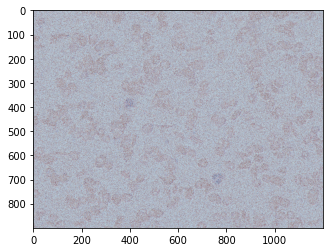

In [ ]:
#Salt-and-pepper-noise
grainy_imgs={}

for status in total_imgs:
    grainy_imgs[status]=[]
    for img in total_imgs[status]:
      new_img = imaugs.shuffle_pixels(img, factor=0.85)
      grainy_imgs[status].append(new_img)

imgplot = plt.imshow(imaugs.shuffle_pixels(Image.open(sickle_dir[0]),factor=0.85))

total_imgs['healthy'] += grainy_imgs['healthy']
total_imgs['sickle'] += grainy_imgs['sickle']

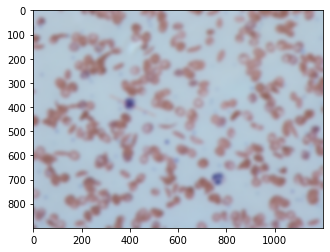

In [ ]:
#Blur
blur_imgs={}

for status in total_imgs:
    blur_imgs[status]=[]
    for img in total_imgs[status]:
      new_img = imaugs.blur(img,radius=7.5)
      blur_imgs[status].append(new_img)

imgplot = plt.imshow(imaugs.blur(Image.open(sickle_dir[0]),radius=7.5))

total_imgs['healthy'] += blur_imgs['healthy']
total_imgs['sickle'] += blur_imgs['sickle']

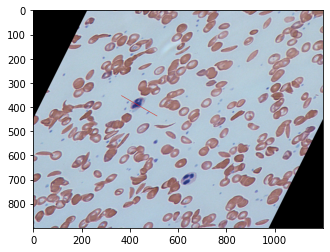

In [ ]:
#Skew
skew_imgs={}

for status in total_imgs:
    skew_imgs[status]=[]
    for img in total_imgs[status]:
      new_img = imaugs.skew(img)
      skew_imgs[status].append(new_img)

imgplot = plt.imshow(imaugs.skew(Image.open(sickle_dir[0])))

total_imgs['healthy'] += skew_imgs['healthy']
total_imgs['sickle'] += skew_imgs['sickle']

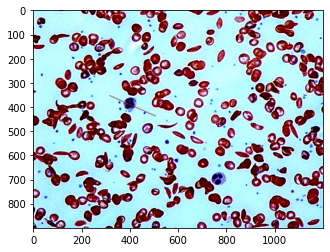

In [ ]:
#Contrast
contrast_imgs={}

for status in total_imgs:
    contrast_imgs[status]=[]
    for img in total_imgs[status]:
      new_img = imaugs.contrast(img, factor=3.5)
      contrast_imgs[status].append(new_img)

imgplot = plt.imshow(imaugs.contrast(Image.open(sickle_dir[0]),factor=3.5))

total_imgs['healthy'] += contrast_imgs['healthy']
total_imgs['sickle'] += contrast_imgs['sickle']

In [ ]:
len(total_imgs['sickle'])

6528

In [ ]:
#Lastly, we're going to quarter every single image. 
split_imgs={}
for status in total_imgs:
    split_imgs[status]=[]
    for img in total_imgs[status]:
        split_imgs[status]+=split(asarray(img),16)

OK, so now each of our classes has ~24k images, for a total of ~50k images.

Let's make a multilayer perceptron and get to it.

In [ ]:
#Create the labels. Binary classifier with sickle=0, healthy=1. We have ~35 images
#of each class. 
full_healthy_labels = len(split_imgs['healthy'])*[0]
full_sickle_labels = len(split_imgs['sickle'])*[1]

#Join for one final label list.
y_full=asarray(full_healthy_labels+full_sickle_labels)

#Join all data arrays for a final dataset. 
X_full=asarray(split_imgs['healthy']+split_imgs['sickle'])

No way we can use leave-one-out cross-validation, it would take an impossible amount of time. We're going to do a 75-25 train-test split. 

In [ ]:
#sklearn can create our train and test tests for us.
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X_final=[]
for _ in X_full:
    X_final.append(np.reshape(_,(768)))
X_final=asarray(X_final)

X_train, X_test, y_train, y_test = train_test_split(X_final, y_full)

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(200,), max_iter=300).fit(X_train, y_train)

In [ ]:
clf.score(X_test, y_test)

0.6146599264705882

That concludes the MLP experiment. We could try a lot more in the way of fine-tuning to boost this model, but in reality, since we are dealing with image structures we need a convolution neural network -- the design of which is beyond the scope of this tutorial. We would need to use libraries such as PyTorch or TensorFlow to construct them.